In [7]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(monocle3, quietly = T)
    library(SeuratWrappers, quietly = T)
    
    library(ggplot2, quietly = T)
    library(cowplot, quietly = T)
})


data_path = '/data3/hratch/norcross_abc/'

Associated tutorials:

1) https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/
2) http://htmlpreview.github.io/?https://github.com/satijalab/seurat-wrappers/blob/master/docs/monocle3.html
3) https://stuartlab.org/signac/articles/monocle.html

In [ ]:
# Load and format T cell data to get just the CD8s

In [82]:
abc.tcells<-readRDS(paste0(data_path, 'processed/abc_tcells.RDS'))
Idents(abc.tcells)<-'Cell.Type.Level2'
# backup<-abc.tcells

Subset to just the CD8+ T cells

In [169]:
abc.cd8s.all<-abc.tcells[, unname(sapply(as.character(abc.tcells$Cell.Type.Level2), function(x) startsWith(x, 'CD8+')))]
abc.cd8s.so<-Seurat::SplitObject(abc.cd8s.all, split.by = 'orig.ident')

Do the trajectory analysis:

In [161]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, cell.type="CD8+ TN"){
  cell_ids <- which(colData(cds)[, "Cell.Type.Level2"] == cell.type)
  
  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}

For now, try two different methods:

**METHOD 1**: calculate trajectory on each condition separately

In [195]:
abc.cd8s <- lapply(X = abc.cd8s.so, FUN = function(x){
    x<-SeuratWrappers::as.cell_data_set(x)
    x<-monocle3::cluster_cells(cds = x)
    x<-monocle3::learn_graph(cds = x)#, use_partition = F) 

#     cd8_tn<-rownames(colData(x)[x$Cell.Type.Level2 == 'CD8+ TN', ])
#     x<-monocle3::order_cells(x, root_cells = cd8_tn) # get trajectory with CD8 TN as root
    x <- order_cells(x, root_pr_nodes=get_earliest_principal_node(x))
})

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [196]:
traj.plots<-list()
for (i in seq_along(abc.cd8s)){

    g1<-DimPlot(abc.cd8s.so[[i]]) + ggtitle(paste0('Condition: ', names(abc.cd8s)[[i]]))
    
#     if (i != length(abc.cd8s)){
#         g1<-g1 + theme(legend.position="none")
#     }
    
    g2<-plot_cells(cds = abc.cd8s[[i]], color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
                   trajectory_graph_segment_size = 0.3,
              label_cell_groups=FALSE, label_roots = FALSE,
               label_leaves=TRUE,
               label_branch_points=TRUE)
    g<-cowplot::plot_grid(g1, g2, ncol = 1)#g1 + g2
    traj.plots[[names(abc.cd8s)[[i]]]]<-g
}

Gray circles are leaves and blue circles are branch points:

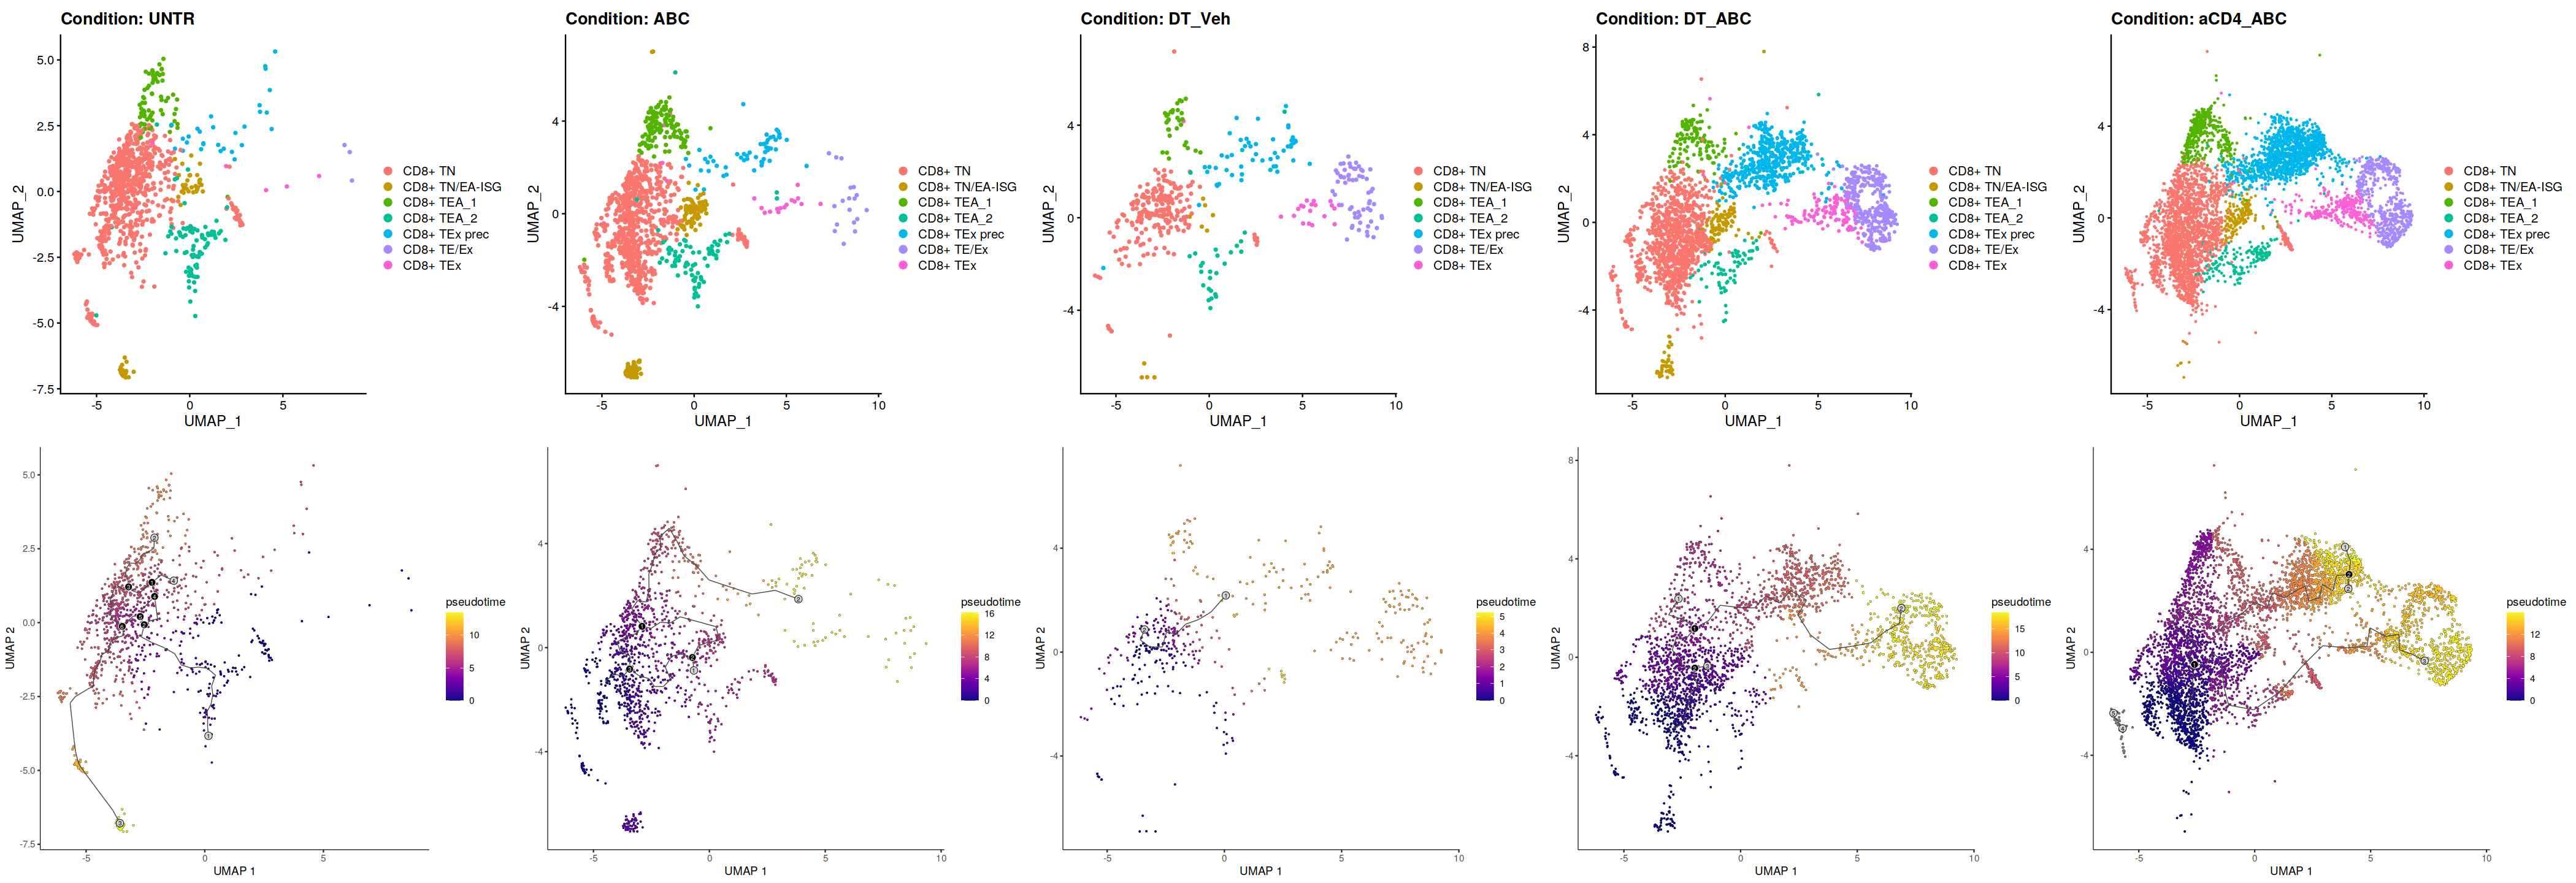

In [197]:
h_ = 12
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

g1<-cowplot::plot_grid(plotlist=traj.plots, ncol = length(traj.plots))

for (ext in c('.svg', '.png', '.pdf')){
    fn<-paste0(data_path, 'figures/', 'cd8_trajectory_separate', ext)
    ggsave(fn, g1, height = h_, width = w_)}

g1

**METHOD 2**: calculate trajectory on all condition together

In [201]:
abc.cd8s <- SeuratWrappers::as.cell_data_set(abc.cd8s.all)
abc.cd8s<-monocle3::cluster_cells(cds = abc.cd8s)
abc.cd8s<-monocle3::learn_graph(cds = abc.cd8s)#, use_partition = F) 

# cd8_tn<-rownames(colData(abc.cd8s)[abc.cd8s$Cell.Type.Level2 == 'CD8+ TN', ])
# abc.cd8s<-monocle3::order_cells(abc.cd8s, root_cells = cd8_tn) # get trajectory with CD8 TN as root
abc.cd8s <- order_cells(abc.cd8s, root_pr_nodes=get_earliest_principal_node(abc.cd8s))

  |======================================================================| 100%


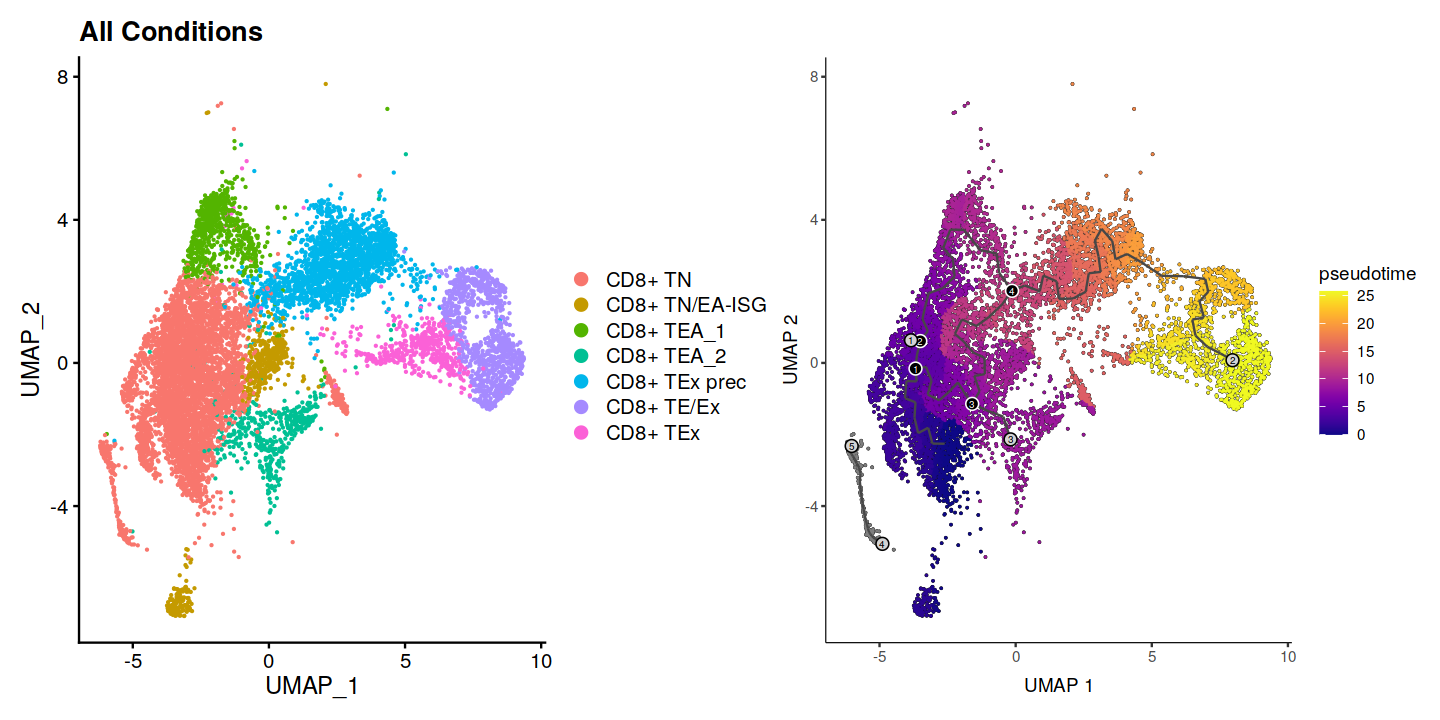

In [206]:
h_ = 6
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

g1A<-DimPlot(abc.cd8s.all) + ggtitle('All Conditions')
g1B<-plot_cells(cds = abc.cd8s, color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
               trajectory_graph_segment_size = 0.5,
          label_cell_groups=FALSE, label_roots = FALSE,
           label_leaves=TRUE,
           label_branch_points=TRUE)
g1<-g1A+g1B

for (ext in c('.svg', '.png', '.pdf')){
    fn<-paste0(data_path, 'figures/', 'cd8_trajectory_all', ext)
    ggsave(fn, g1, height = h_, width = w_)}

g1

In [208]:
traj.plots<-list()
conditions <- unique(abc.cd8s$orig.ident)
for (i in seq_along(conditions)){
    g1<-DimPlot(abc.cd8s.so[[i]]) + ggtitle(paste0('Condition: ', conditions[[i]]))
    
#     if (i != length(abc.cd8s)){
#         g1<-g1 + theme(legend.position="none")
#     }
    
    g2<-plot_cells(cds = abc.cd8s[, abc.cd8s$orig.ident == conditions[[i]]], 
                   color_cells_by = "pseudotime", show_trajectory_graph = TRUE, 
                   trajectory_graph_segment_size = 0.3,
              label_cell_groups=FALSE, label_roots = FALSE,
               label_leaves=TRUE,
               label_branch_points=TRUE)
    g<-cowplot::plot_grid(g1, g2, ncol = 1)#g1 + g2
    traj.plots[[conditions[[i]]]]<-g
}

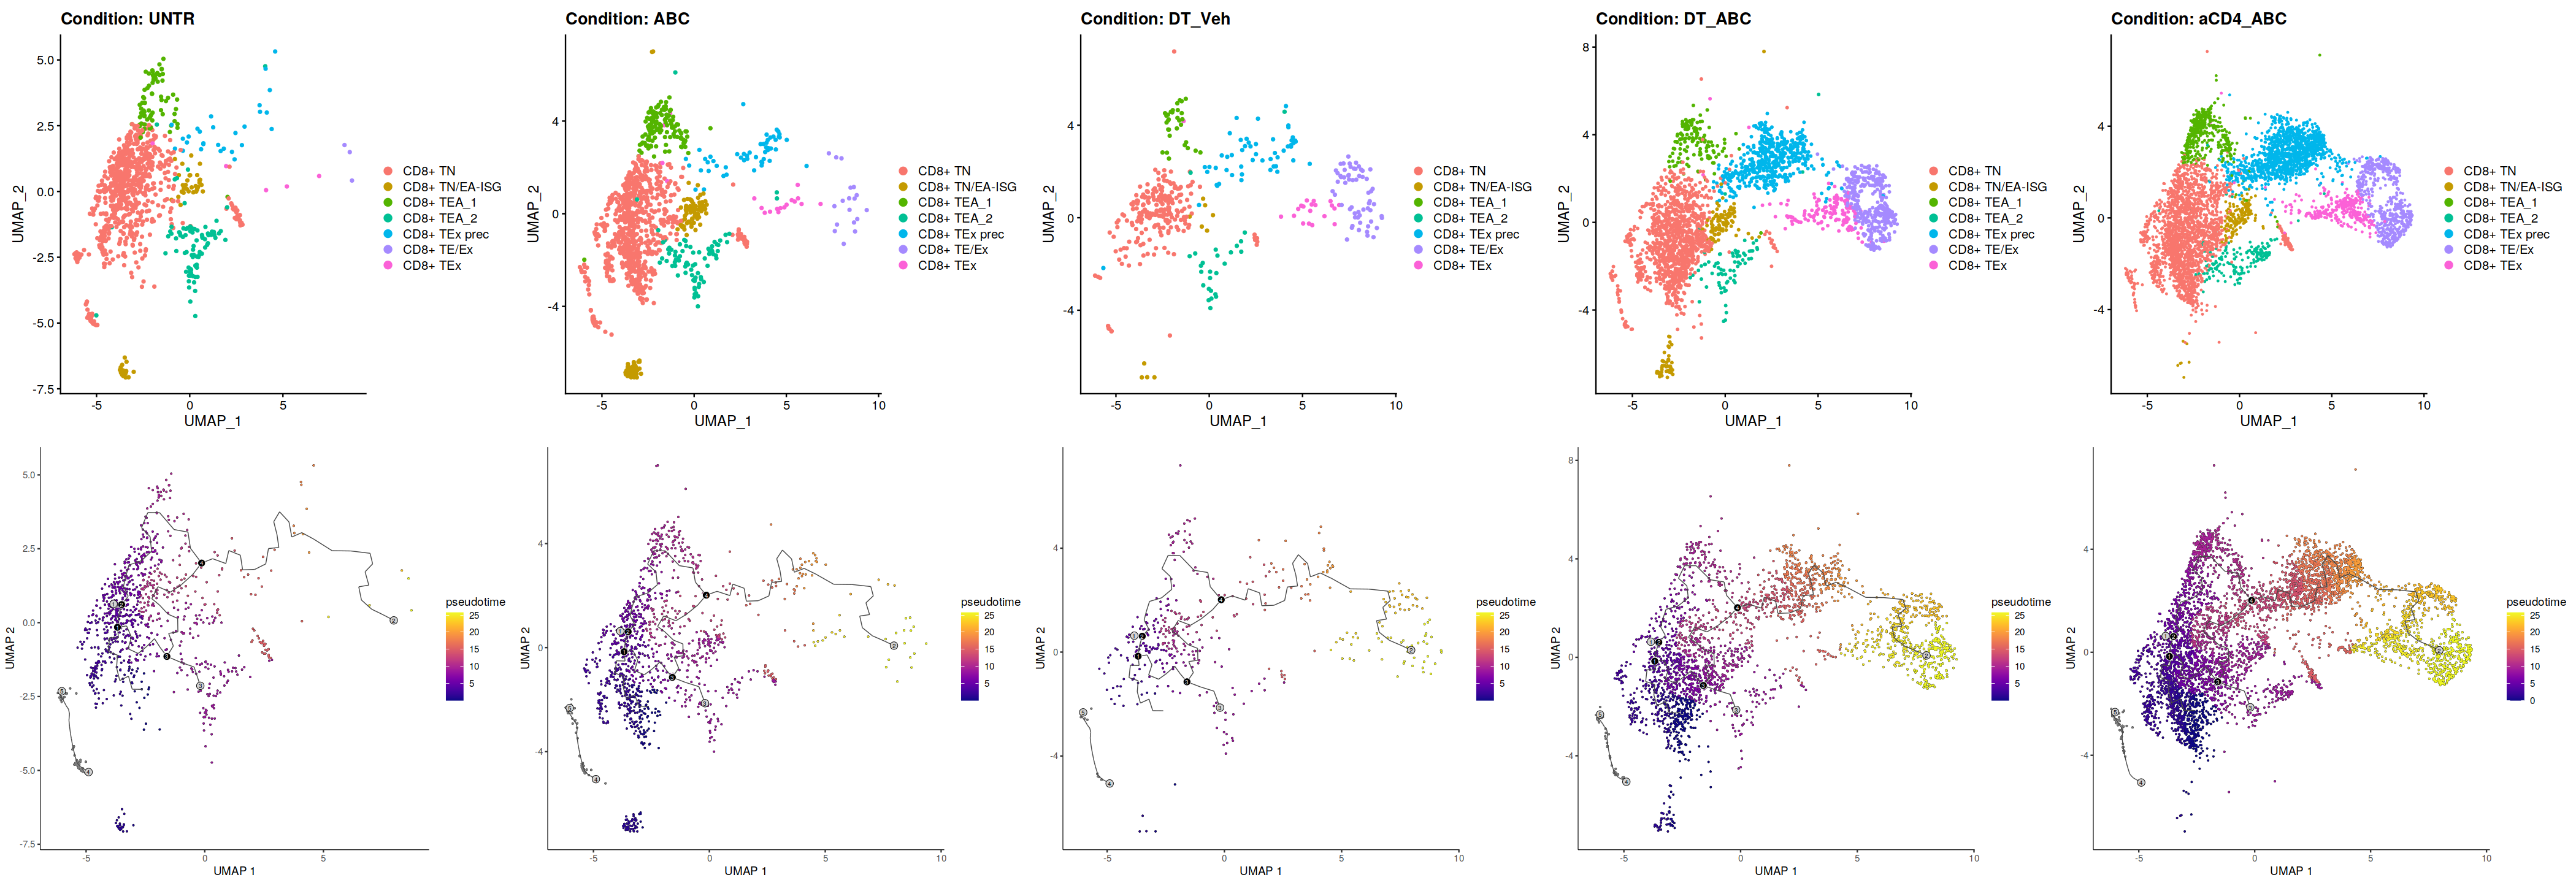

In [210]:
h_ = 12
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

g2<-cowplot::plot_grid(plotlist=traj.plots, ncol = length(traj.plots))

for (ext in c('.svg', '.png', '.pdf')){
    fn<-paste0(data_path, 'figures/', 'cd8_trajectory_all_bycondition', ext)
    ggsave(fn, g2, height = h_, width = w_)}

g2